# LLM Validation Metrics Analysis

This notebook analyzes the impact and effectiveness of LLM-based validation on the knowledge graph nodes. It compares heuristic classifications with LLM corrections and provides detailed metrics on type changes, correction rates, and Lore resolution.

## Step 1: Load Libraries and Configure Visualization

Import all required libraries for data analysis and visualization. Set up matplotlib and seaborn themes for consistent, professional-looking charts.

In [24]:
# 1. Setup and import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.metrics import confusion_matrix

# Configure visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("Libraries loaded successfully.")

Libraries loaded successfully.


## Step 2: Load and Merge Data

Load two datasets:
- **Original nodes**: Results from heuristic rule-based classification
- **Validated nodes**: Results from LLM validation

Merge them by node ID to compare and identify which types were changed by the LLM.

In [25]:
# 2. Configuration and data loading
DATA_DIR = os.path.join("..", "data", "processed")
ORIGINAL_NODES_PATH = os.path.join(DATA_DIR, "nodes.jsonl")
VALIDATED_NODES_PATH = os.path.join(DATA_DIR, "nodes_validated.jsonl")

# Load heuristic nodes (rule-based classification)
# Extract: ID, type, confidence, and type scores
try:
    df_orig = pd.read_json(ORIGINAL_NODES_PATH, lines=True)
    df_orig = df_orig[['id', 'type', 'confidence', 'type_scores']].rename(
        columns={'type': 'type_rule', 'confidence': 'conf_rule'}
    )
except FileNotFoundError:
    print(f"ERROR: File not found at {ORIGINAL_NODES_PATH}. Run the scraper first.")
    df_orig = pd.DataFrame()

# Load LLM-validated nodes
try:
    df_val = pd.read_json(VALIDATED_NODES_PATH, lines=True)
    df_val = df_val[['id', 'type', 'confidence', 'reason']].rename(
        columns={'type': 'type_llm', 'confidence': 'conf_llm', 'reason': 'llm_reason'}
    )
except FileNotFoundError:
    print(f"ERROR: File not found at {VALIDATED_NODES_PATH}. Run the LLM validator first.")
    df_val = pd.DataFrame()

# Merge datasets by ID and identify changes
if not df_orig.empty and not df_val.empty:
    df = pd.merge(df_orig, df_val, on='id', how='inner')
    df['changed'] = df['type_rule'] != df['type_llm']
    print(f"✅ Data merged successfully. Total nodes: {len(df)}")
    display(df.head())
else:
    df = pd.DataFrame()
    print("Could not proceed with analysis due to data loading errors.")

✅ Data merged successfully. Total nodes: 5483


,id,type_rule,conf_rule,type_scores,type_llm,conf_llm,llm_reason,changed
0,A.J. Kennedy,Lore,Low,"{'Character': 0, 'House': 0, 'Organization': 0...",Character,High (LLM),The entity is an actor who portrayed a charact...,True
1,A Golden Crown,Episode,High,"{'Character': 0, 'House': 0, 'Organization': 0...",Episode,High,Score: 13,False
2,A Golden Crown/Appearances,Object,Medium,"{'Character': 0, 'House': 0, 'Organization': 0...",Lore,High (LLM),This entity is a meta-page listing appearances...,True
3,A Golden Crown (short),Object,Medium,"{'Character': 0, 'House': 0, 'Organization': 0...",Episode,High (LLM),This entity describes a specific short video (...,True
4,A Knight of the Seven Kingdoms,Lore,Low,"{'Character': 0, 'House': 0, 'Organization': 0...",Lore,High (LLM),This entity describes an entire upcoming telev...,False


## Step 3: Calculate and Visualize Correction Rates

Analyze how many nodes were changed by the LLM validation compared to the heuristic rules. Display the intervention percentage and the top reasons for corrections. Export corrections to CSV for manual review and auditing.

📊 CORRECTION RATE (OVERTURN RATE)
Total Nodes: 5483
Nodes Corrected by LLM: 1520
Intervention Percentage: 27.72%


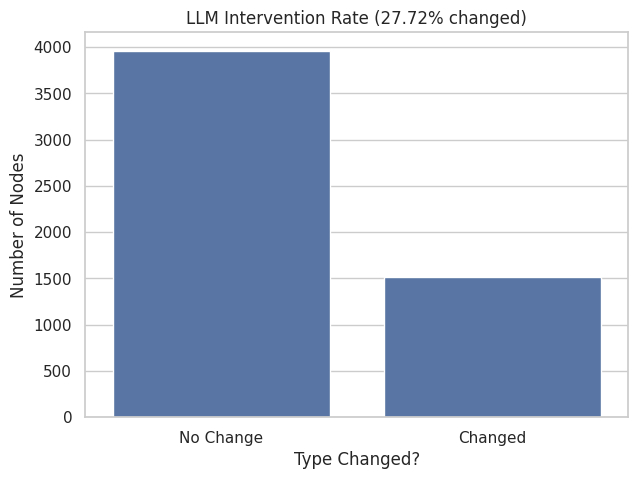


Top 5 Correction Reasons:


llm_reason
Entity is an actor playing a role in Game of Thrones, aligning with Rule 1.                                            9
This entity refers to a 'Histories & Lore' short, which is supplementary content, not an in-universe entity itself.    7
This describes a specific, pivotal event or conflict, fitting the 'Battle' category for named conflicts.               7
Explicitly described as a "street in King's Landing".                                                                  6
Entity is explicitly described as a podcast episode with an episode number, date, and runtime.                         6
Name: count, dtype: int64


Corrections CSV saved for audit at '../data/processed/llm_corrections_audit.csv'


In [26]:
# 3. Correction rate analysis
if not df.empty:
    total_nodes = len(df)
    nodes_changed = df['changed'].sum()
    pct_change = (nodes_changed / total_nodes) * 100
    
    print("="*40)
    print("📊 CORRECTION RATE (OVERTURN RATE)")
    print("="*40)
    print(f"Total Nodes: {total_nodes}")
    print(f"Nodes Corrected by LLM: {nodes_changed}")
    print(f"Intervention Percentage: {pct_change:.2f}%")
    
    # 3.1 Intervention chart
    plt.figure(figsize=(7, 5))
    sns.countplot(x='changed', data=df)
    plt.title(f'LLM Intervention Rate ({pct_change:.2f}% changed)')
    plt.xlabel('Type Changed?')
    plt.xticks([0, 1], ['No Change', 'Changed'])
    plt.ylabel('Number of Nodes')
    plt.show()

    # 3.2 Audit: Review most frequent correction reasons
    print("\nTop 5 Correction Reasons:")
    display(df[df['changed']]['llm_reason'].value_counts().head(5))
    
    # Save corrections to CSV for manual audit
    audit_df = df[df['changed']][['id', 'type_rule', 'type_llm', 'llm_reason', 'conf_rule']]
    audit_df.to_csv(os.path.join(DATA_DIR, "llm_corrections_audit.csv"), index=False)
    print(f"\nCorrections CSV saved for audit at '{DATA_DIR}/llm_corrections_audit.csv'")

## Step 4: Type Migration Matrix Analysis

Create a confusion matrix showing all type transitions from heuristic rules to LLM corrections. The diagonal shows correct classifications (no change), while off-diagonal values indicate how types were remapped by the LLM. This helps identify systematic classification errors in the heuristic rules.

🗺️ TYPE MIGRATION MATRIX


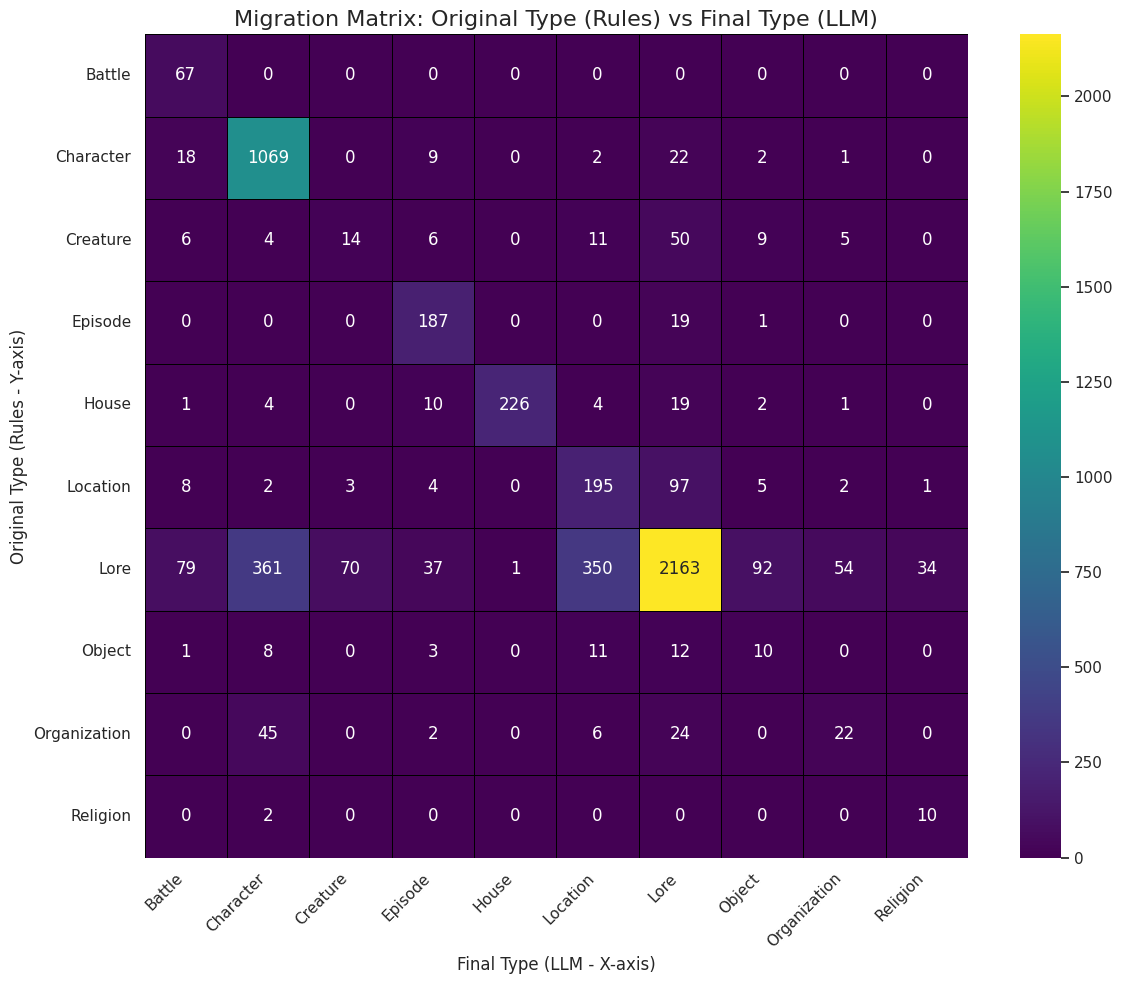


Matrix Interpretation:
- The diagonal (top-left to bottom-right) shows correct predictions (Rule == LLM).
- Values off the diagonal show corrections. For example, a high value in 'Organization' row and 'Character' column means heuristics misclassified many organizations that LLM corrected to characters.


In [27]:
# 4. Type migration matrix (confusion matrix)
if not df.empty and nodes_changed > 0:
    print("="*40)
    print("🗺️ TYPE MIGRATION MATRIX")
    print("="*40)
    
    # Get all unique labels to ensure square matrix
    labels = sorted(list(set(df['type_rule'].unique()) | set(df['type_llm'].unique())))
    
    # Create confusion matrix
    cm = confusion_matrix(df['type_rule'], df['type_llm'], labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(12, 10))
    
    # Show numbers in cells
    sns.heatmap(cm_df, 
                annot=True, 
                fmt='d',  # Integer format
                cmap='viridis', 
                linewidths=0.5, 
                linecolor='black')
    
    plt.title('Migration Matrix: Original Type (Rules) vs Final Type (LLM)', fontsize=16)
    plt.ylabel('Original Type (Rules - Y-axis)')
    plt.xlabel('Final Type (LLM - X-axis)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\nMatrix Interpretation:")
    print("- The diagonal (top-left to bottom-right) shows correct predictions (Rule == LLM).")
    print("- Values off the diagonal show corrections. For example, a high value in 'Organization' row and 'Character' column means heuristics misclassified many organizations that LLM corrected to characters.")

## Step 5: Lore Node Resolution Analysis

Analyze how many uncertain 'Lore' nodes (fallback category when type is ambiguous) were successfully resolved into specific types by the LLM. This metric shows the value of LLM validation in improving classification confidence. Display the distribution of new types assigned to previously uncertain nodes.

✨ RESOLUTION OF 'LORE' NODES (UNCERTAIN)
Total nodes originally classified as 'Lore': 3241
Nodes re-classified (Resolved): 1078
Resolution Percentage: 33.26%


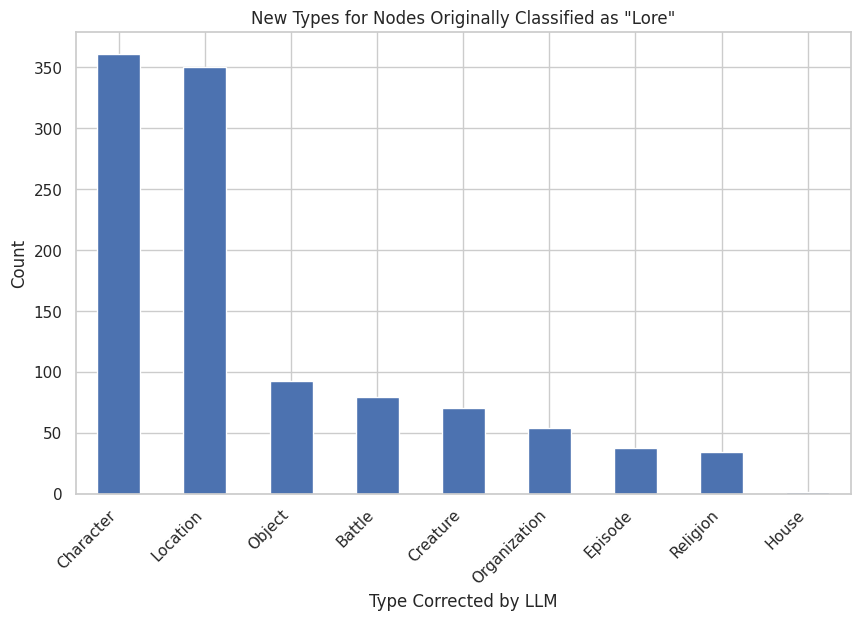


LLM primarily converted 'Lore' nodes to:


type_llm
Character    361
Location     350
Object        92
Battle        79
Creature      70
Name: count, dtype: int64

In [28]:
# 5. Analysis of 'Lore' resolution
if not df.empty:
    df_lore_original = df[df['type_rule'] == 'Lore'].copy()
    total_lore = len(df_lore_original)
    
    if total_lore > 0:
        resolved_lore = df_lore_original[df_lore_original['type_llm'] != 'Lore']
        
        print("="*40)
        print("✨ RESOLUTION OF 'LORE' NODES (UNCERTAIN)")
        print("="*40)
        print(f"Total nodes originally classified as 'Lore': {total_lore}")
        print(f"Nodes re-classified (Resolved): {len(resolved_lore)}")
        print(f"Resolution Percentage: {(len(resolved_lore)/total_lore)*100:.2f}%")
        
        if not resolved_lore.empty:
            plt.figure(figsize=(10, 6))
            resolved_lore['type_llm'].value_counts().plot(kind='bar')
            plt.title('New Types for Nodes Originally Classified as "Lore"')
            plt.xlabel('Type Corrected by LLM')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.show()

            print("\nLLM primarily converted 'Lore' nodes to:")
            display(resolved_lore['type_llm'].value_counts().head())
        else:
            print("LLM did not re-classify any 'Lore' nodes to another category.")
    else:
        print("No nodes were originally classified as 'Lore' by the heuristic rules.")